In [8]:

from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess

from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nibabel import Nifti1Image
import cortex
import nibabel as nib


from matplotlib.colors import Normalize
def Vertex2D_fix(data1, data2, subject, cmap, vmin, vmax, vmin2, vmax2, roi_borders=None):
    #this provides a nice workaround for pycortex opacity issues, at the cost of interactivity    
    # Get curvature
    curv = cortex.db.get_surfinfo(subject)
    # Adjust curvature contrast / color. Alternately, you could work
    # with curv.data, maybe threshold it, and apply a color map. 
    #standard
    curv.data = curv.data * .75 +0.1
    #alternative
    #curv.data = np.sign(curv.data) * .25
    #HCP adjustment
    #curv.data = curv.data * -2.5# 1.25 +0.1
    curv = cortex.Vertex(curv.data, subject, vmin=-1,vmax=1,cmap='gray')
    norm2 = Normalize(vmin2, vmax2)   
    vx = cortex.Vertex(data1, subject, cmap=cmap, vmin=vmin, vmax=vmax)
    # Map to RGB
    vx_rgb = np.vstack([vx.raw.red.data, vx.raw.green.data, vx.raw.blue.data])
    curv_rgb = np.vstack([curv.raw.red.data, curv.raw.green.data, curv.raw.blue.data])
    # Pick an arbitrary region to mask out
    # (in your case you could use np.isnan on your data in similar fashion)
    alpha = np.clip(norm2(data2), 0, 1)
    # Alpha mask
    display_data = (curv_rgb * (1-alpha)) + vx_rgb * alpha
    display_data /= 255
    #print(display_data.min())
    #print(display_data.max())
    if roi_borders is not None:
        display_data[:,roi_borders.astype('bool')] = 0#255-display_data[:,roi_borders.astype('bool')]#0#255
    
    # Create vertex RGB object out of R, G, B channels
    return cortex.VertexRGB(*display_data, subject) 




from AOTanalysis.voxelmotion.filter_info import FilterInfo

backend = set_backend("numpy", on_error="warn")



In [9]:
sub = 3
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside/model_sub{sub}_feature_motion32_trainses_1_Xcentered_True_Yzscore_True_Xstd_True_testinside.joblib"
model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1_2_3.joblib"
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1.joblib"
model = joblib.load(model_path)

In [10]:

R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/R2_score_single_sub{sub}_motion_train_1_2_3_test_4.nii.gz"

R2 = nib.load(R2_file)
R2_data = R2.get_fdata()
print("R2_data shape:", R2_data.shape)
R2_data = np.transpose(R2_data, (2, 1, 0))
print("Transposed R2_data shape:", R2_data.shape)



R2_data shape: (84, 95, 106)
Transposed R2_data shape: (106, 95, 84)


In [11]:
primal_coef = model[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
# primal_coef /= np.linalg.norm(primal_coef, axis=0)[None]
# primal_coef *= np.sqrt(np.maximum(0, scores))[None]
print("n_features, n_voxels) =", primal_coef.shape)

max_index = np.argmax(primal_coef, axis=0)
print("max_index.shape =", max_index.shape)

n_features, n_voxels) = torch.Size([11845, 352914])
max_index.shape = torch.Size([352914])


In [12]:
filter_info = FilterInfo()
# aspect_ratio = filter_info.pyramid.parameters["aspect_ratio"]
# print("aspect_ratio =", aspect_ratio)

polar_angles = np.zeros(max_index.shape)
for i in range(max_index.shape[0]):
    polar_angles[i] = filter_info.index_to_polar_angle(max_index[i])
print("Polar angles shape:", polar_angles.shape)

polar_angles_volume = reshape_from_flatten_masked_to_wholebrain(polar_angles,sub=sub)
print("Polar angles volume shape:", polar_angles_volume.shape)

# Transpose the volume to match the expected shape (106, 95, 84)
polar_angles_volume = np.transpose(polar_angles_volume, (2, 1, 0))
print("Transposed polar angles volume shape:", polar_angles_volume.shape)

#save to /tank/shared/2024/visual/AOT/temp/motion_energy_analysis/motion2polar as nifti





save_path = Path(f"/tank/shared/2024/visual/AOT/temp/motion_energy_analysis/motion2polar_maxindex")
save_path.mkdir(parents=True, exist_ok=True)


glminfo = GLMSingleAccess()
affine = glminfo.read_affine(sub)
header = glminfo.read_header(sub)

# nifti_img = Nifti1Image(polar_angles_volume, affine=affine, header=header)
# nifti_img.to_filename(save_path / f"polar_angles_sub{sub}.nii.gz")


Polar angles shape: (352914,)
Polar angles volume shape: (84, 95, 106)
Transposed polar angles volume shape: (106, 95, 84)


Caching mapper...
Caching mapper...


/tank/zhangs/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Unable to init server: Could not connect: Connection refused
** (inkscape:3083864): WARNING **: 09:42:37.326: Fonts dir '/tank/zhangs/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:1878.27:1024 exported to 1878 x 1024 pixels (96 dpi)
Unable to init server: Could not connect: Connection refused
** (inkscape:3083884): WARNING **: 09:42:37.902: Fonts dir '/tank/zhangs/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:1878.27:1024 exported to 1878 x 1024 pixels (96 dpi)


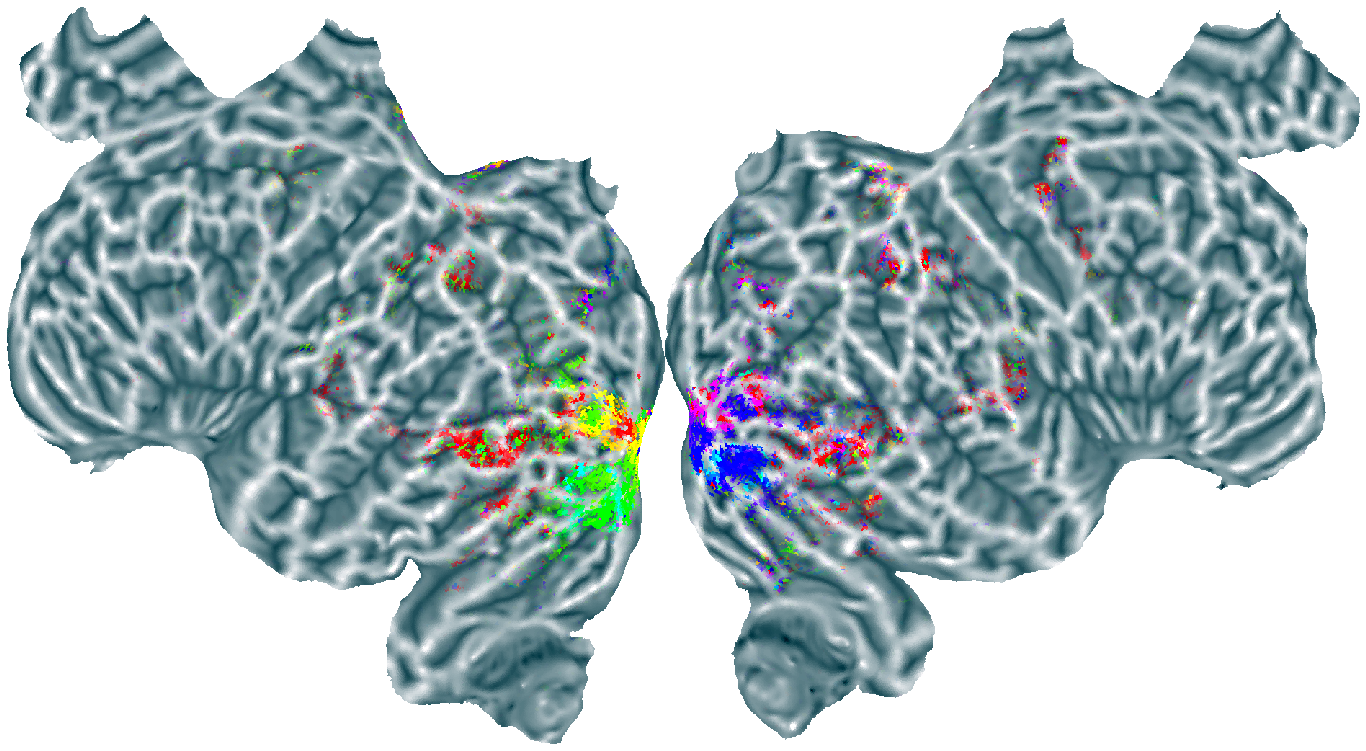

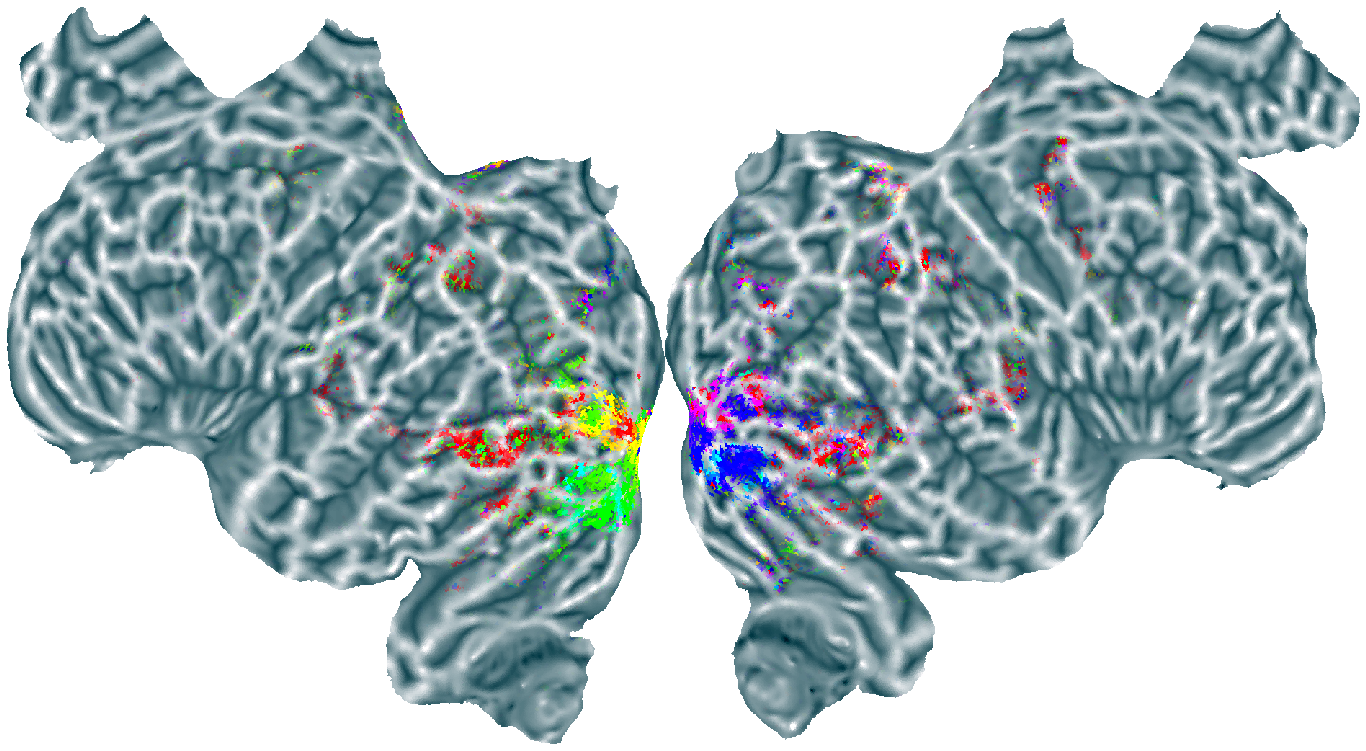

In [13]:
# Note: The polar_angles_volume has been transposed to match the expected shape for cortex.Volume
sub = "sub-003"
volume = cortex.Volume(polar_angles_volume, sub, "AOT1pt7mm", recache=True)
mapper = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map = mapper(volume)

volume_R2 = cortex.Volume(R2_data, sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map_R2 = mapper_R2(volume_R2)


selected_cmap = "hsv"  # Change this to your desired colormap
native_surface_map.cmap = selected_cmap
native_surface_map.vmin = 0
native_surface_map.vmax = 360




merged_map = Vertex2D_fix(
    native_surface_map.data,
    native_surface_map_R2.data,
    sub,
    cmap="hsv",
    vmin=0,
    vmax=360,
    vmin2=0,
    vmax2=0.3,
)


# Set colormap
selected_cmap = "hsv"  # Change this to your desired colormap
native_surface_map.cmap = selected_cmap

cortex.quickshow(
    merged_map,
    with_curvature=False,
    with_colorbar=False,
    with_labels=False,
    with_sulci=True,
    with_legend=False,
    cmap=selected_cmap,
    colorbar_label="Polar Angle",
)



In [24]:
# Save native_surface_map
# 'sub' (integer 3) is from cell 4832c652
# 'save_path' is from cell aca1e5af
import pickle
filename = save_path / f"native_surface_map_MEpolar_{sub}.pkl"
with open(filename, "wb") as f:
    pickle.dump(merged_map, f)
print(f"Saved native_surface_map to {filename}")

Saved native_surface_map to /tank/shared/2024/visual/AOT/temp/motion_energy_analysis/motion2polar_maxindex/native_surface_map_MEpolar_sub-003.pkl
